<a href="https://colab.research.google.com/github/Sevethseal/ML_projects/blob/main/Retail_Price_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip -q install xgboost==2.0.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.6 MB/s eta 0:00:00


In [ ]:
import io, requests, pandas as pd, numpy as np

UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

def load_uciretail():
    r = requests.get(UCI_URL, timeout=120)
    r.raise_for_status()
    df = pd.read_excel(io.BytesIO(r.content))
    # basic clean
    df = df.dropna(subset=["InvoiceNo","StockCode","Description","Quantity","InvoiceDate","UnitPrice","Country"])
    df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]          # drop credit notes
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]              # positive qty & price
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    return df

try:
    raw = load_uciretail()
    print(raw.shape, "rows/cols:", raw.shape)
except Exception as e:
    print("Download failed, generating synthetic fallback:", e)
    rng = np.random.default_rng(42)
    n = 100_000
    raw = pd.DataFrame({
        "InvoiceNo": rng.integers(100000, 999999, n).astype(str),
        "StockCode": [f"S{rng.integers(1000, 9999)}" for _ in range(n)],
        "Description": [f"Item {i}" for i in range(n)],
        "Quantity": rng.integers(1, 20, n),
        "InvoiceDate": pd.to_datetime("2010-12-01") + pd.to_timedelta(rng.integers(0, 370*24, n), unit="h"),
        "UnitPrice": np.round(rng.normal(5, 3, n).clip(0.2, 50), 2),
        "CustomerID": rng.integers(10000, 20000, n),
        "Country": rng.choice(["United Kingdom","Germany","France","Netherlands","Spain"], size=n, p=[0.7,0.1,0.08,0.07,0.05])
    })
    print("Synthetic rows:", len(raw))

raw.head()


(530104, 8) rows/cols: (530104, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Shape:", raw.shape)
print("\nColumns:", raw.columns.tolist())
print("\nMissing values:\n", raw.isna().sum())
print("\nUnique products:", raw['StockCode'].nunique())
print("Unique customers:", raw['CustomerID'].nunique())
print("Countries:", raw['Country'].nunique())
raw.head()


Shape: (530104, 8)

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Missing values:
 InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

Unique products: 3922
Unique customers: 4338
Countries: 38


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


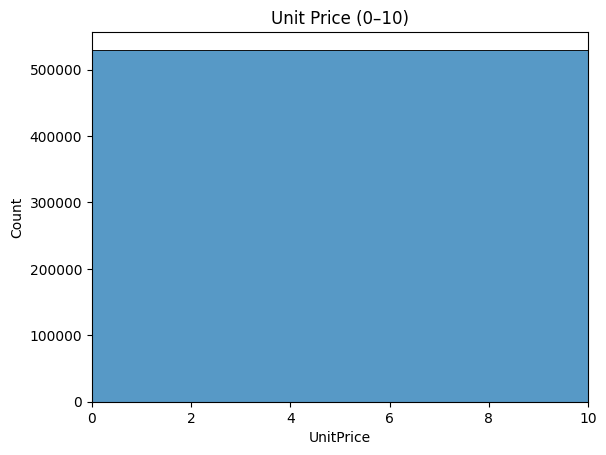

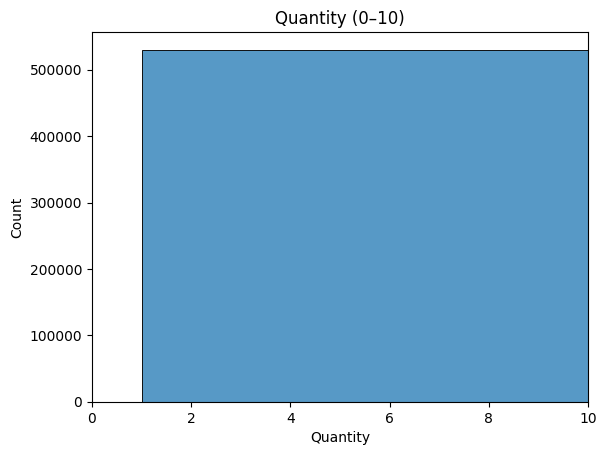

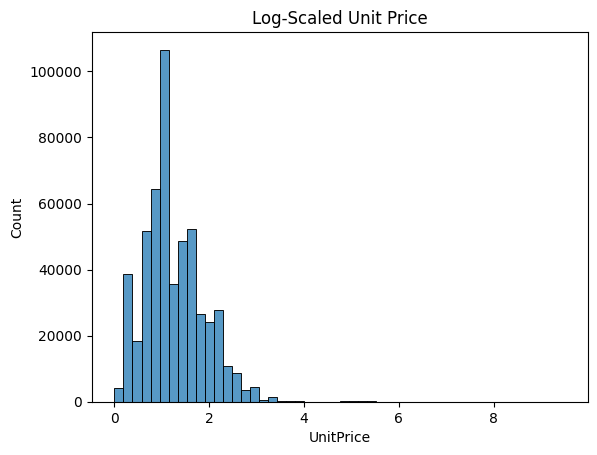

In [ ]:
# Zoom into 0–10 for both
sns.histplot(raw['UnitPrice'], bins=50)
plt.xlim(0, 10)
plt.title("Unit Price (0–10)")
plt.show()

sns.histplot(raw['Quantity'], bins=50)
plt.xlim(0, 10)
plt.title("Quantity (0–10)")
plt.show()

# Or log-scale
sns.histplot(np.log1p(raw['UnitPrice']), bins=50)
plt.title("Log-Scaled Unit Price")
plt.show()



In [ ]:
print("UnitPrice stats:")
print(raw['UnitPrice'].describe(percentiles=[0.5,0.9,0.95,0.99]))

print("\nQuantity stats:")
print(raw['Quantity'].describe(percentiles=[0.5,0.9,0.95,0.99]))


UnitPrice stats:
count    530104.000000
mean          3.907625
std          35.915681
min           0.001000
50%           2.080000
90%           7.950000
95%           9.950000
99%          16.980000
max       13541.330000
Name: UnitPrice, dtype: float64

Quantity stats:
count    530104.000000
mean         10.542037
std         155.524124
min           1.000000
50%           3.000000
90%          24.000000
95%          30.000000
99%         100.000000
max       80995.000000
Name: Quantity, dtype: float64


In [ ]:
import pandas as pd

def list_outliers(df, col, method="percentile", thresh=0.99):
    """
    List outliers in a column.

    df : DataFrame
    col : column name
    method : "percentile" (default) or "iqr"
    thresh : percentile threshold (default 0.99 = top 1%)

    Returns DataFrame of outlier rows.
    """
    series = df[col].copy()

    if method == "percentile":
        cutoff = series.quantile(thresh)
        outliers = df[series > cutoff]

    elif method == "iqr":
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        upper = Q3 + 1.5*IQR
        lower = Q1 - 1.5*IQR
        outliers = df[(series > upper) | (series < lower)]

    else:
        raise ValueError("method must be 'percentile' or 'iqr'")

    print(f"Total rows: {len(df)}, Outliers in '{col}': {len(outliers)}")
    return outliers

# Example usage:
price_outliers = list_outliers(raw, "UnitPrice", method="percentile", thresh=0.99)
qty_outliers   = list_outliers(raw, "Quantity", method="percentile", thresh=0.99)

print("Price outliers head:\n", price_outliers[['StockCode','Description','UnitPrice']].head())
print("\nQuantity outliers head:\n", qty_outliers[['StockCode','Description','Quantity']].head())


Total rows: 530104, Outliers in 'UnitPrice': 5075
Total rows: 530104, Outliers in 'Quantity': 4849
Price outliers head:
     StockCode                         Description  UnitPrice
45       POST                             POSTAGE      18.00
168     22783    SET 3 WICKER OVAL BASKETS W LIDS      19.95
246     22827  RUSTIC  SEVENTEEN DRAWER SIDEBOARD     165.00
294     22803            IVORY EMBROIDERED QUILT       35.75
431     22803            IVORY EMBROIDERED QUILT       35.75

Quantity outliers head:
     StockCode                      Description  Quantity
96      21212  PACK OF 72 RETROSPOT CAKE CASES       120
178     79321                    CHILLI LIGHTS       192
179     22780   LIGHT GARLAND BUTTERFILES PINK       192
180     22779       WOODEN OWLS LIGHT GARLAND        192
181     22466    FAIRY TALE COTTAGE NIGHTLIGHT       432


In [11]:
import numpy as np
import pandas as pd

def clean_retail(
    df: pd.DataFrame,
    *,
    # price rules
    price_min=0.10,           # drop <= this
    price_max=None,           # hard cap; if None, use price_q
    price_q=0.99,             # percentile cap when price_max is None
    # quantity rules
    qty_min=1,                # drop < this (removes negative/zero -> returns)
    qty_max=None,             # hard cap; if None, use qty_q
    qty_q=0.99,               # percentile cap when qty_max is None
    # invoice outliers
    drop_outlier_invoices=True,
    invoice_q=0.99,           # drop invoices above this total percentile
    # misc
    drop_credit_notes=True,   # drop InvoiceNo starting with 'C'
    drop_duplicates=True,
    winsorize=False,          # if True, cap values instead of dropping above caps
    verbose=True
):
    """Clean UCI Online Retail-style data and return (df_clean, report dict)."""

    df = df.copy()
    n0 = len(df)
    report = {"n0": n0, "steps": []}

    # Ensure types & basic columns
    if "InvoiceDate" in df.columns and not np.issubdtype(df["InvoiceDate"].dtype, np.datetime64):
        df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
    for c in ["InvoiceNo","StockCode","Description","Country"]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()

    # 0) Drop credit notes/returns by InvoiceNo pattern
    if drop_credit_notes and "InvoiceNo" in df.columns:
        before = len(df)
        df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
        report["steps"].append({"drop_credit_notes": int(before - len(df))})

    # 1) Drop obvious missing/invalids
    required = ["InvoiceNo","StockCode","Description","Quantity","UnitPrice","InvoiceDate","Country"]
    have = [c for c in required if c in df.columns]
    before = len(df)
    df = df.dropna(subset=have)
    report["steps"].append({"drop_na_required": int(before - len(df))})

    # 2) Drop non-positive prices / quantities (remove returns & freebies/mistakes)
    before = len(df)
    df = df[(df["UnitPrice"] > price_min) & (df["Quantity"] >= qty_min)]
    report["steps"].append({"drop_nonpositive": int(before - len(df))})

    # 3) Compute invoice totals for later
    df["line_total"] = df["Quantity"] * df["UnitPrice"]
    inv_sum = df.groupby("InvoiceNo", as_index=False)["line_total"].sum().rename(columns={"line_total":"invoice_total"})
    df = df.merge(inv_sum, on="InvoiceNo", how="left")

    # 4) Determine caps (from percentiles if hard caps not provided)
    if price_max is None:
        price_max = df["UnitPrice"].quantile(price_q)  # ~ 99th ≈ £17 on this dataset
    if qty_max is None:
        qty_max = df["Quantity"].quantile(qty_q)       # ~ 99th ≈ 100 on this dataset

    # 5) Apply caps or drop outliers (price, quantity)
    def cap_or_drop(series, lower=None, upper=None, wins=False, label=""):
        before = len(series)
        if wins:
            s = series.clip(lower=lower if lower is not None else -np.inf,
                            upper=upper if upper is not None else np.inf)
            removed = 0
            return s, removed
        else:
            mask = pd.Series(True, index=series.index)
            if lower is not None: mask &= series >= lower
            if upper is not None: mask &= series <= upper
            removed = int(before - mask.sum())
            return series.where(mask, np.nan), removed

    # Price
    df["UnitPrice"], removed_price = cap_or_drop(df["UnitPrice"], price_min, price_max, winsorize, "UnitPrice")
    # Quantity
    df["Quantity"], removed_qty = cap_or_drop(df["Quantity"], qty_min, qty_max, winsorize, "Quantity")

    # If dropping (not winsorizing), remove the NaNs created above
    if not winsorize:
        before = len(df)
        df = df.dropna(subset=["UnitPrice","Quantity"])
        actually_dropped = int(before - len(df))
    else:
        actually_dropped = 0

    report["steps"].append({
        "price_cap": float(price_max),
        "qty_cap": float(qty_max),
        "removed_price_outliers": int(removed_price if not winsorize else 0),
        "removed_qty_outliers": int(removed_qty if not winsorize else 0),
        "winsorized": bool(winsorize),
        "dropped_due_to_capping_nan": actually_dropped
    })

    # 6) Drop invoices with extreme totals (bulk/wholesale)
    if drop_outlier_invoices:
        inv_cut = df["invoice_total"].quantile(invoice_q)
        before = len(df)
        keep_inv = df["invoice_total"] <= inv_cut
        removed = int(before - keep_inv.sum())
        df = df[keep_inv]
        report["steps"].append({"drop_outlier_invoices_above": float(inv_cut), "removed_rows": removed})

    # 7) Optional: drop duplicates
    if drop_duplicates:
        before = len(df)
        df = df.drop_duplicates()
        report["steps"].append({"drop_duplicates": int(before - len(df))})

    # 8) Final sanity: remove any lingering non-positive totals
    before = len(df)
    df = df[(df["UnitPrice"] > 0) & (df["Quantity"] > 0)]
    report["steps"].append({"final_nonpositive_filter": int(before - len(df))})

    # 9) Finish
    report["n_final"] = len(df)
    report["kept_ratio"] = round(len(df) / n0, 4)

    if verbose:
        print(f"Cleaned rows: {report['n_final']} / {n0} (keep {100*report['kept_ratio']:.2f}%)")
        for s in report["steps"]:
            print(s)

    # Drop helper columns if you don't want them downstream
    df = df.drop(columns=["line_total","invoice_total"], errors="ignore")
    return df.reset_index(drop=True), report


In [12]:
print("UnitPrice stats:")
print(raw['UnitPrice'].describe(percentiles=[0.5,0.9,0.95,0.99]))

print("\nQuantity stats:")
print(raw['Quantity'].describe(percentiles=[0.5,0.9,0.95,0.99]))


UnitPrice stats:
count    530104.000000
mean          3.907625
std          35.915681
min           0.001000
50%           2.080000
90%           7.950000
95%           9.950000
99%          16.980000
max       13541.330000
Name: UnitPrice, dtype: float64

Quantity stats:
count    530104.000000
mean         10.542037
std         155.524124
min           1.000000
50%           3.000000
90%          24.000000
95%          30.000000
99%         100.000000
max       80995.000000
Name: Quantity, dtype: float64


In [13]:
cleaned, report = clean_retail(raw, price_max=100, qty_max=1000, winsorize=False)
print(cleaned['UnitPrice'].describe(percentiles=[0.5,0.9,0.95,0.99]))
print(cleaned['Quantity'].describe(percentiles=[0.5,0.9,0.95,0.99]))


Cleaned rows: 518399 / 530104 (keep 97.79%)
{'drop_credit_notes': 0}
{'drop_na_required': 0}
{'drop_nonpositive': 303}
{'price_cap': 100.0, 'qty_cap': 1000.0, 'removed_price_outliers': 811, 'removed_qty_outliers': 102, 'winsorized': False, 'dropped_due_to_capping_nan': 913}
{'drop_outlier_invoices_above': 8980.88, 'removed_rows': 5267}
{'drop_duplicates': 5222}
{'final_nonpositive_filter': 0}
count    518399.000000
mean          3.294277
std           3.812862
min           0.120000
50%           2.080000
90%           7.950000
95%           9.950000
99%          16.950000
max         100.000000
Name: UnitPrice, dtype: float64
count    518399.000000
mean          9.456976
std          25.658123
min           1.000000
50%           3.000000
90%          24.000000
95%          25.000000
99%         100.000000
max        1000.000000
Name: Quantity, dtype: float64


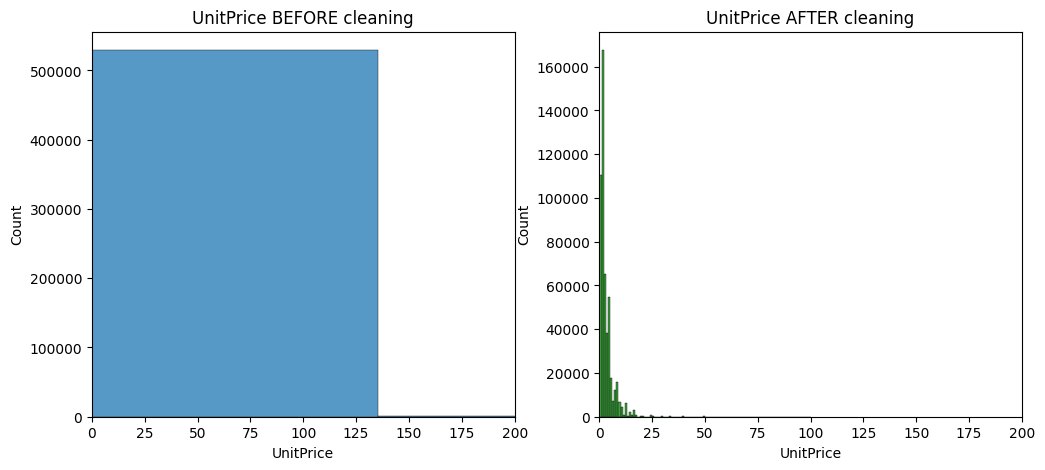

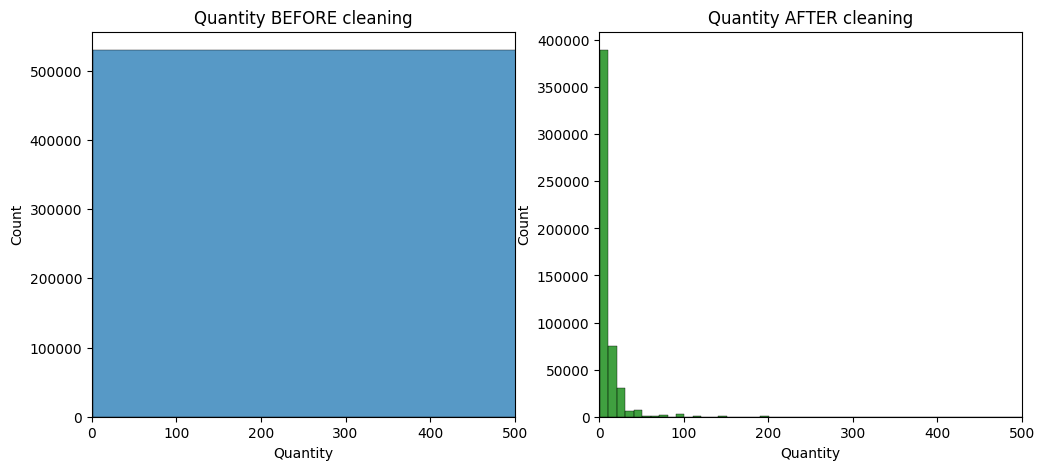

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_histograms(raw, cleaned, col, xmax=None, bins=100):
    plt.figure(figsize=(12,5))

    # Before
    plt.subplot(1,2,1)
    sns.histplot(raw[col], bins=bins, kde=False)
    if xmax: plt.xlim(0, xmax)
    plt.title(f"{col} BEFORE cleaning")

    # After
    plt.subplot(1,2,2)
    sns.histplot(cleaned[col], bins=bins, kde=False, color="green")
    if xmax: plt.xlim(0, xmax)
    plt.title(f"{col} AFTER cleaning")

    plt.show()

# Example: price and quantity
compare_histograms(raw, cleaned, "UnitPrice", xmax=200)
compare_histograms(raw, cleaned, "Quantity", xmax=500)


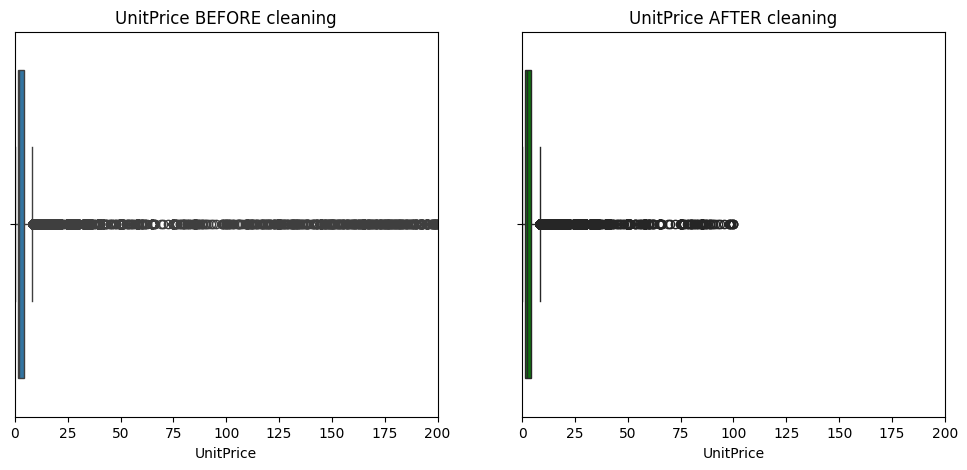

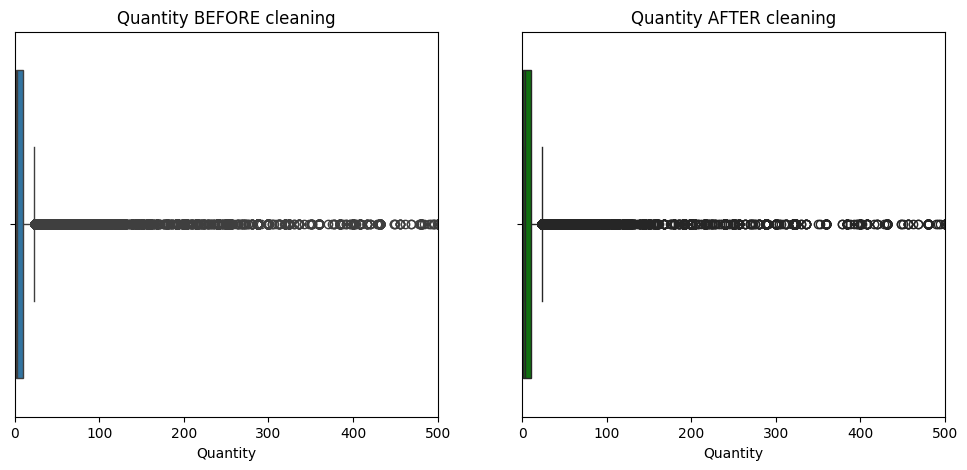

In [15]:
def compare_boxplots(raw, cleaned, col, xmax=None):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    sns.boxplot(x=raw[col])
    if xmax: plt.xlim(0, xmax)
    plt.title(f"{col} BEFORE cleaning")

    plt.subplot(1,2,2)
    sns.boxplot(x=cleaned[col], color="green")
    if xmax: plt.xlim(0, xmax)
    plt.title(f"{col} AFTER cleaning")

    plt.show()

# Example
compare_boxplots(raw, cleaned, "UnitPrice", xmax=200)
compare_boxplots(raw, cleaned, "Quantity", xmax=500)


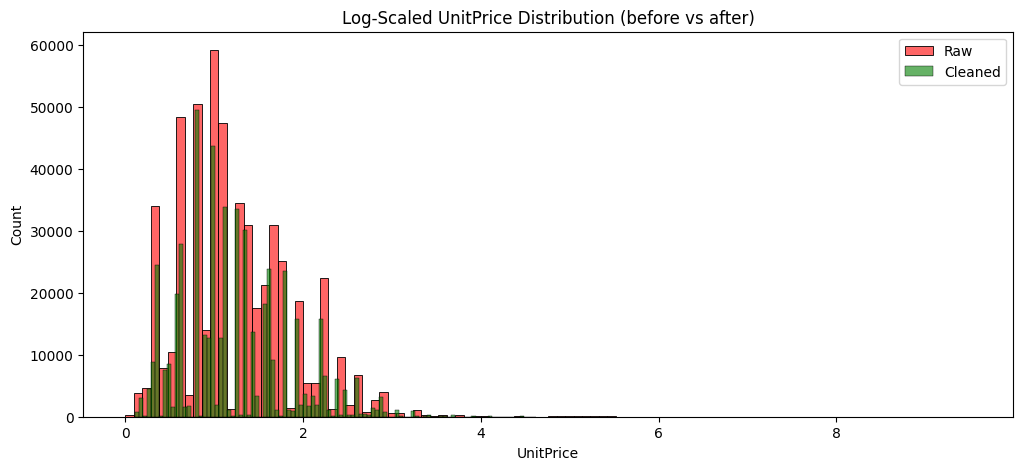

In [16]:
plt.figure(figsize=(12,5))

sns.histplot(np.log1p(raw["UnitPrice"]), bins=100, label="Raw", color="red", alpha=0.6)
sns.histplot(np.log1p(cleaned["UnitPrice"]), bins=100, label="Cleaned", color="green", alpha=0.6)
plt.title("Log-Scaled UnitPrice Distribution (before vs after)")
plt.legend()
plt.show()


In [17]:
import pandas as pd
import numpy as np

def build_features(df: pd.DataFrame):
    df = df.copy()
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

    # --- 🕒 Time Features ---
    df["month"] = df["InvoiceDate"].dt.month
    df["day_of_week"] = df["InvoiceDate"].dt.dayofweek
    df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)

    # --- 💰 Transaction Features ---
    df["line_total"] = df["Quantity"] * df["UnitPrice"]
    inv_totals = df.groupby("InvoiceNo")["line_total"].sum().rename("invoice_total")
    items_per_inv = df.groupby("InvoiceNo")["Quantity"].sum().rename("items_per_transaction")
    df = df.merge(inv_totals, on="InvoiceNo", how="left")
    df = df.merge(items_per_inv, on="InvoiceNo", how="left")

    # --- 📦 Product Demand Features ---
    grp = df.groupby("StockCode")
    total_qty = grp["Quantity"].sum().rename("total_quantity_sold")
    avg_price = grp["UnitPrice"].mean().rename("avg_price")
    price_vol = grp["UnitPrice"].std().fillna(0).rename("price_volatility")
    unique_cust = grp["CustomerID"].nunique().rename("unique_customers")
    repeat_rate = (grp["CustomerID"].nunique() / grp["InvoiceNo"].nunique()).rename("repeat_purchase_rate")

    df = df.merge(total_qty, on="StockCode", how="left") \
           .merge(avg_price, on="StockCode", how="left") \
           .merge(price_vol, on="StockCode", how="left") \
           .merge(unique_cust, on="StockCode", how="left") \
           .merge(repeat_rate, on="StockCode", how="left")

    # --- 📊 Price Features ---
    df["avg_price_gap"] = df["UnitPrice"] - df["avg_price"]

    # --- 📈 Rolling demand (7 transactions per product) ---
    df = df.sort_values(["StockCode","InvoiceDate"])
    df["rolling_avg_qty_7"] = df.groupby("StockCode")["Quantity"].transform(lambda s: s.rolling(7, min_periods=1).mean())

    # --- ⏳ Seasonal Index (monthly demand / avg demand) ---
    mon_sales = df.groupby(["StockCode","month"])["Quantity"].sum().rename("monthly_sales").reset_index()
    base_sales = df.groupby("StockCode")["Quantity"].sum().rename("product_total").reset_index()
    tmp = mon_sales.merge(base_sales, on="StockCode", how="left")
    tmp["seasonal_index"] = tmp["monthly_sales"] / (tmp["product_total"]/12)
    df = df.merge(tmp[["StockCode","month","seasonal_index"]], on=["StockCode","month"], how="left")
    df["seasonal_index"] = df["seasonal_index"].fillna(1.0).clip(0,10)

    # --- 🌍 Geography Features ---
    df["is_uk"] = (df["Country"] == "United Kingdom").astype(int)
    top_countries = df["Country"].value_counts().head(5).index
    for c in top_countries:
        df[f"country_{c.replace(' ','_')}"] = (df["Country"] == c).astype(int)

    return df


In [18]:
features = build_features(cleaned)
print(features.head())

print("Shape:", features.shape)
print("Columns:", features.columns.tolist())

  InvoiceNo StockCode                 Description  Quantity  \
0    536370     10002  INFLATABLE POLITICAL GLOBE      48.0   
1    536382     10002  INFLATABLE POLITICAL GLOBE      12.0   
2    536756     10002  INFLATABLE POLITICAL GLOBE       1.0   
3    536863     10002  INFLATABLE POLITICAL GLOBE       1.0   
4    536865     10002  INFLATABLE POLITICAL GLOBE       5.0   

          InvoiceDate  UnitPrice  CustomerID         Country  month  \
0 2010-12-01 08:45:00       0.85     12583.0          France     12   
1 2010-12-01 09:45:00       0.85     16098.0  United Kingdom     12   
2 2010-12-02 14:23:00       0.85         NaN  United Kingdom     12   
3 2010-12-03 11:19:00       0.85     17967.0  United Kingdom     12   
4 2010-12-03 11:28:00       1.66         NaN  United Kingdom     12   

   day_of_week  ...  repeat_purchase_rate  avg_price_gap  rolling_avg_qty_7  \
0            2  ...               0.56338       -0.23662          48.000000   
1            2  ...               0.

In [19]:
from sklearn.model_selection import train_test_split

# 🎯 Target variable
y = features["UnitPrice"].values

# 🧾 Feature set (drop non-features like IDs, text, timestamps)
drop_cols = ["InvoiceNo","StockCode","Description","InvoiceDate","Country","CustomerID","UnitPrice"]
X = features.drop(columns=[c for c in drop_cols if c in features.columns])

print("Final features shape:", X.shape)
print("Example feature columns:", X.columns[:10].tolist())

# Split into training and testing (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Final features shape: (518399, 21)
Example feature columns: ['Quantity', 'month', 'day_of_week', 'is_weekend', 'line_total', 'invoice_total', 'items_per_transaction', 'total_quantity_sold', 'avg_price', 'price_volatility']
Train shape: (414719, 21) Test shape: (103680, 21)


Final X shape: (518399, 21) y shape: (518399,)
{
  "RandomForest": {
    "MAE": 0.0030376813271811433,
    "RMSE": 0.0902994631417713,
    "R2": 0.9994395885668296
  },
  "XGBoost": {
    "MAE": 0.02363970729201043,
    "RMSE": 0.16062333179541868,
    "R2": 0.9982268155638467
  },
  "NeuralNet": {
    "MAE": 0.025928250016771074,
    "RMSE": 0.038322613081626905,
    "R2": 0.9998990638166136
  },
  "Ensemble(0.4/0.3/0.3)": {
    "MAE": 0.013836828585149234,
    "RMSE": 0.08244444049836443,
    "R2": 0.9995328467222346
  }
}

Top 10 RF features:
                  feature  importance
8              avg_price    0.800800
12         avg_price_gap    0.192594
4             line_total    0.004949
9       price_volatility    0.000541
11  repeat_purchase_rate    0.000286
7    total_quantity_sold    0.000236
10      unique_customers    0.000206
0               Quantity    0.000168
1                  month    0.000046
5          invoice_total    0.000043


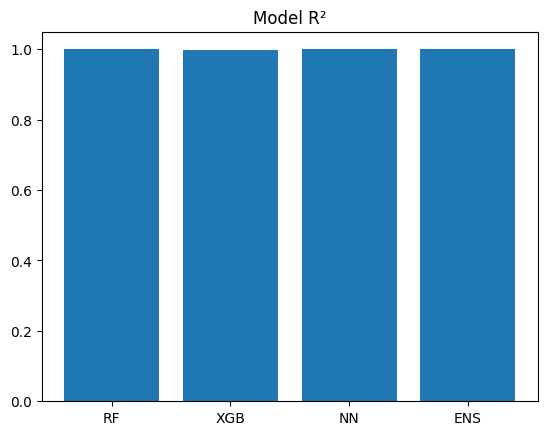

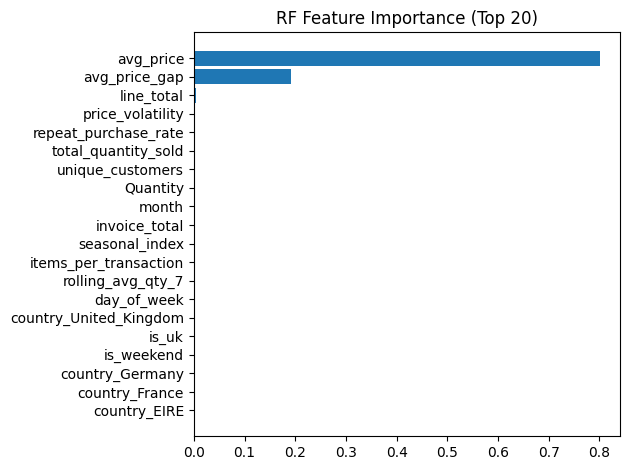

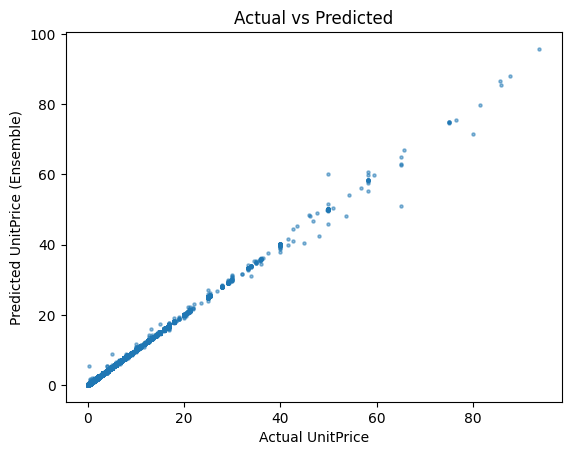

In [21]:
# TRAIN RF + XGB + SIMPLE NN, THEN ENSEMBLE & METRICS

import numpy as np
import pandas as pd
import math, json, warnings
warnings.filterwarnings("ignore")

# 1) Build X, y from your engineered features -------------------------------
from sklearn.model_selection import train_test_split

# Target
y = features["UnitPrice"].astype(float).values

# Drop identifiers / raw text / timestamps from features
drop_cols = ["InvoiceNo","StockCode","Description","InvoiceDate","Country","CustomerID","UnitPrice"]
X = features.drop(columns=[c for c in drop_cols if c in features.columns])

print("Final X shape:", X.shape, "y shape:", y.shape)

# Split
RSEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

# 2) Define helper for metrics ----------------------------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics(y_true, y_pred):
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(math.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# 3) Train Random Forest -----------------------------------------------------
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200, n_jobs=-1, random_state=RSEED
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 4) Train XGBoost -----------------------------------------------------------
# If you haven’t installed:  !pip -q install xgboost==2.0.3
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    random_state=RSEED,
    n_jobs=-1,
    objective="reg:squarederror",
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# 5) Train simple Neural Net (2 layers) -------------------------------------
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.keras.utils.set_random_seed(RSEED)

# Make sure we pass float32 numpy arrays (not DataFrames) to Keras
X_train_np = np.asarray(X_train, dtype="float32")
X_test_np  = np.asarray(X_test,  dtype="float32")
y_train_np = np.asarray(y_train, dtype="float32")
y_test_np  = np.asarray(y_test,  dtype="float32")

# Create and adapt the Normalization layer *before* building the model
norm = keras.layers.Normalization()
norm.adapt(X_train_np)

nn = keras.Sequential([
    keras.layers.Input(shape=(X_train_np.shape[1],)),
    norm,
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])

nn.compile(optimizer="adam", loss="mse")
nn.fit(X_train_np, y_train_np, epochs=8, batch_size=1024, verbose=0)
nn_pred = nn.predict(X_test_np, verbose=0).ravel()

# 6) Weighted Ensemble -------------------------------------------------------
# Weights per your plan: 0.40 XGB, 0.30 RF, 0.30 NN
ens_pred = 0.40 * xgb_pred + 0.30 * rf_pred + 0.30 * nn_pred

# 7) Report metrics ----------------------------------------------------------
perf = {
    "RandomForest": metrics(y_test, rf_pred),
    "XGBoost":      metrics(y_test, xgb_pred),
    "NeuralNet":    metrics(y_test, nn_pred),
    "Ensemble(0.4/0.3/0.3)": metrics(y_test, ens_pred)
}
print(json.dumps(perf, indent=2))

# 8) Optional: feature importances & quick plots -----------------------------
# (You can comment this block out if you want only metrics)

# Feature importances (RF + XGB)
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

try:
    xgb_importance = pd.DataFrame({
        "feature": X.columns,
        "importance": xgb.feature_importances_
    }).sort_values("importance", ascending=False)
except Exception:
    xgb_importance = pd.DataFrame(columns=["feature","importance"])

# Save / preview artifacts if you like
print("\nTop 10 RF features:\n", rf_importance.head(10))

# Optional visuals inline
import matplotlib.pyplot as plt

# R² bar chart
names = ["RF","XGB","NN","ENS"]
r2_vals = [perf["RandomForest"]["R2"], perf["XGBoost"]["R2"], perf["NeuralNet"]["R2"], perf["Ensemble(0.4/0.3/0.3)"]["R2"]]
plt.figure()
plt.bar(names, r2_vals)
plt.title("Model R²")
plt.show()

# RF Feature Importance (Top 20)
top = rf_importance.head(20)
plt.figure()
plt.barh(top["feature"][::-1], top["importance"][::-1])
plt.title("RF Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

# Actual vs Predicted (Ensemble)
plt.figure()
plt.scatter(y_test, ens_pred, s=5, alpha=0.5)
plt.xlabel("Actual UnitPrice")
plt.ylabel("Predicted UnitPrice (Ensemble)")
plt.title("Actual vs Predicted")
plt.show()

# 9) (Optional) Keep handy objects in variables for later use
models = {"rf": rf, "xgb": xgb, "nn": nn}
preds_df = pd.DataFrame({"y_true": y_test, "rf": rf_pred, "xgb": xgb_pred, "nn": nn_pred, "ensemble": ens_pred})


                            MAE      RMSE        R2
RandomForest           0.003038  0.090299  0.999440
XGBoost                0.023640  0.160623  0.998227
NeuralNet              0.025928  0.038323  0.999899
Ensemble(0.4/0.3/0.3)  0.013837  0.082444  0.999533


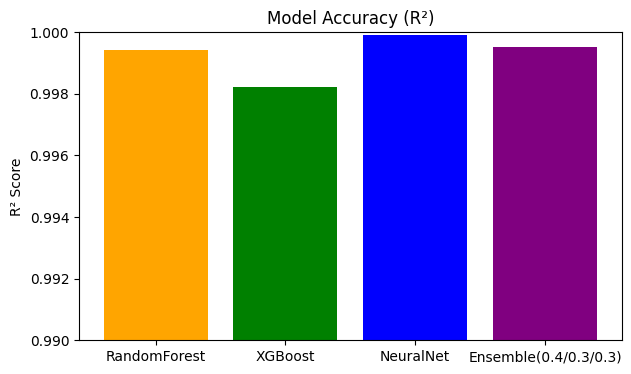

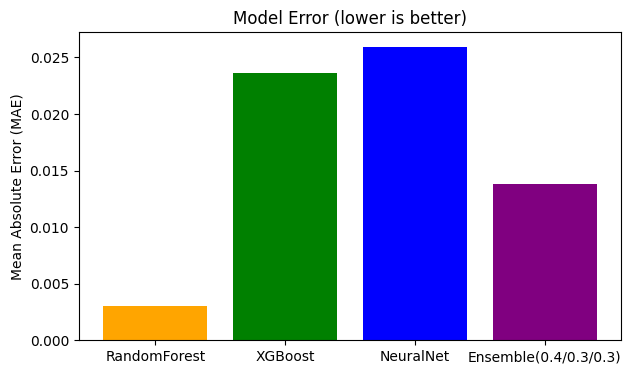

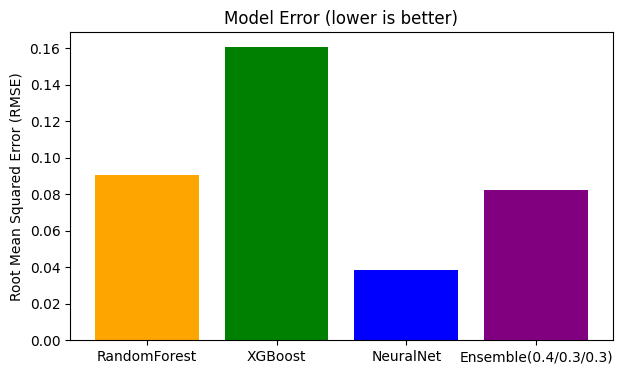

In [22]:


# Convert your metrics dict into a DataFrame
perf_df = pd.DataFrame(perf).T  # rows = models, cols = MAE/RMSE/R2
print(perf_df)

# --- 1) R² comparison ---
plt.figure(figsize=(7,4))
plt.bar(perf_df.index, perf_df["R2"], color=["orange","green","blue","purple"])
plt.ylabel("R² Score")
plt.title("Model Accuracy (R²)")
plt.ylim(0.99, 1.0)  # zoom in since all are very high
plt.show()

# --- 2) MAE comparison ---
plt.figure(figsize=(7,4))
plt.bar(perf_df.index, perf_df["MAE"], color=["orange","green","blue","purple"])
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Error (lower is better)")
plt.show()

# --- 3) RMSE comparison ---
plt.figure(figsize=(7,4))
plt.bar(perf_df.index, perf_df["RMSE"], color=["orange","green","blue","purple"])
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model Error (lower is better)")
plt.show()
